In [104]:
from sklearn.linear_model import (
    LinearRegression,
    RidgeClassifierCV,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

## Generate data

In [161]:
d = 2
n_pos = 1000
n_neg = 1000
lambda_pos = [10, .5]#, .3]# , 9, 10]
lambda_neg = [.5, 10]#, 20] #, .2, .1]
X_pos = np.random.poisson(lambda_pos, size=(n_pos, d))
y_pos = np.ones(n_pos)
X_neg = np.random.poisson(lambda_neg, size=(n_neg, d))
y_neg = -1 * np.ones(n_neg)

X = np.vstack([X_pos, X_neg])
y = np.hstack([y_pos, y_neg])

In [162]:
X

array([[ 8,  0],
       [ 8,  1],
       [11,  1],
       ..., 
       [ 0, 14],
       [ 0,  8],
       [ 2,  6]])

In [163]:
y

array([ 1.,  1.,  1., ..., -1., -1., -1.])

## train model

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
lr = RidgeClassifierCV()
lr = LogisticRegressionCV(Cs=10)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [186]:
beta = lr.coef_
beta

array([ 0.09520219, -0.09315356])

In [166]:
# y_pred = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)

Decision line: 
$$\beta_0 * X_{i, 0} + \beta_1 * X_{i, 1} = 0$$
$$X_{i, 0} = \frac{- \beta_1 * X_{i, 1}}{\beta_0}$$

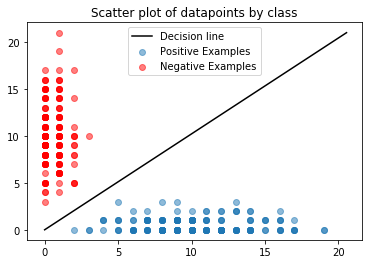

In [192]:
X_1 = np.linspace(X_test[:, 1].min(), X_test[:, 1].max())
X_0 = (-beta[1] * X_1) / beta[0]

neg = np.where(y_test == -1)[0]
pos = np.where(y_test == 1)[0]
plt.scatter(X_test[pos][:, 0], X_test[pos][:, 1], alpha=.5, label='Positive Examples')
plt.scatter(X_test[neg][:, 0], X_test[neg][:, 1], alpha=.5, c='red', label='Negative Examples')
plt.plot(X_0, X_1, label='Decision line', c='black')
plt.legend()
plt.title("Scatter plot of datapoints by class");

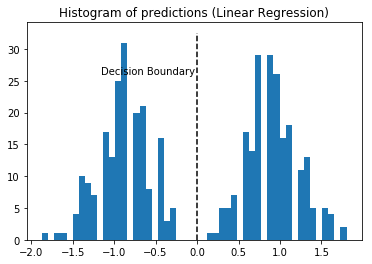

In [167]:
pd.Series(y_pred).hist(bins=50)
plt.title("Histogram of predictions (Linear Regression)")
y_min, y_max = plt.ylim()
plt.vlines(0, y_min, y_max, linestyle="dashed")
plt.text(-.03, y_max* .8, "Decision Boundary", horizontalalignment="right")
plt.grid();

In [168]:
roc_auc_score(y_test, y_pred)

1.0

OK, so our classifier is very accurate on this fake data.

## Find flipsets iteratively

For the 2-dimensional case, the predicted score is calculated using the following linear equation:

$$\beta_0 * (X_{i, 0} + a_0) + \beta_1 * (X_{i, 1} + a_1) = score$$

$a_1^{max}$ is the action set taken when $a_0 = 0$:
$$ a_1^{max} = \frac{- \beta_0 * X_{i, 0}}{\beta_1} - X_{i, 1}$$
So, to generate all flipsets in the 2-dim case, let's just step up towards the max:

For $a_1^{step}$ in $0,1,...,a_1^{max}$:
$$ a_0 = \frac{- (\beta_1 * (X_{i, 1} + a_1))}{\beta_0} - X_{i, 0}$$

In [300]:
def get_flip_set(
    X_i,
    beta, # coefficients of the linear model
    S = None, # set of dimensions to consider
    bounds=None, # boundaries beyond which we can't take an action on X
    decision_boundary=.5 # value of y_pred_i necessary to flip prediction
):
    if not S:
        S = np.arange(len(X_i))
    A_dim = X_i[S] # action set
    A_set = []
    
    a_1_max = (-beta[0] * X_i[0] / beta[1]) - X_i[1]
    sign = np.sign(a_1_max)
    
    rounder = np.floor
    # if a_1_max sign is -1, then beta_0 sign is 1
    if sign == -1:
        rounder = np.ceil

    # cycle through 0 ,..., a_max
    # if a_max is negative, step down
    for a_1_step in np.arange(0, a_1_max + sign, step=sign):
        a_0_step = (-beta[1] * (X_i[1] + a_1_step) / beta[0]) - X_i[0]
        a_0_step = rounder(a_0_step)
        A_set.append((a_0_step, a_1_step))
    return A_set

In [301]:
neg = np.where(y_test == -1)[0]
X_i = X_test[neg][0]

In [302]:
test_flip_set = get_flip_set(X_i, beta)
test_flip_set

[(7.0, 0.0),
 (6.0, -1.0),
 (5.0, -2.0),
 (4.0, -3.0),
 (3.0, -4.0),
 (2.0, -5.0),
 (1.0, -6.0),
 (-0.0, -7.0)]

In [303]:
# check
np.isclose(
    y_pred[0],
    X_i[0] * beta[0] + X_i[1] * beta[1],
    rtol=1e-2,
)

True

In [304]:
for a_0, a_1 in test_flip_set:
    print (X_i[0] + a_0) * beta[0] + (X_i[1] + a_1) * beta[1]

0.0163889774119
0.0143403552354
0.0122917330589
0.0102431108824
0.00819448870594
0.00614586652946
0.00409724435297
0.00204862217649


#### great, all positive! 